## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.fft import fft, ifft, fftfreq
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed

In [2]:
def coe_from_sv(r1, r2, r3, v1, v2, v3):
    mu_Earth_km3_s2 = 3.986004418e5

    r_vec = np.array([r1, r2, r3])
    v_vec = np.array([v1, v2, v3])

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)

    v_r = np.dot(r_vec / r, v_vec)

    h_vec = np.cross(r_vec, v_vec)
    h = np.linalg.norm(h_vec)

    i = np.arccos(h_vec[2] / h)

    K = np.array([0, 0, 1])
    N_vec = np.cross(K, h_vec)
    N = np.linalg.norm(N_vec)

    Omega = np.arccos(N_vec[0] / N)
    if N_vec[1] < 0:
        Omega = 2 * np.pi - Omega

    e_vec = (np.cross(v_vec, h_vec) / mu_Earth_km3_s2) - (r_vec / r)
    e = np.linalg.norm(e_vec)

    omega = np.arccos(np.dot(N_vec, e_vec) / (N * e))
    if e_vec[2] < 0:
        omega = 2 * np.pi - omega

    nu = np.arccos(np.dot(r_vec / r, e_vec / e))
    if v_r < 0:
        nu = 2 * np.pi - nu

    i = np.degrees(i)
    Omega = np.degrees(Omega)
    omega = np.degrees(omega)
    nu = np.degrees(nu)

    return h, e, Omega, i, omega, nu

In [3]:
def return_coe(data):
    obs = data.shape[0]

    h_arr = []
    e_arr = []
    Omega_arr = []
    i_arr = []
    omega_arr = []
    nu_arr = []
    time_arr = []

    for j in range(obs):
        h, e, Omega, i, omega, nu = coe_from_sv(data.at[j, 'J2Kx1'], data.at[j, 'J2Kx2'], data.at[j, 'J2Kx3'], data.at[j, 'J2Kv1'], data.at[j, 'J2Kv2'], data.at[j, 'J2Kv3'])
        h_arr.append(h)
        e_arr.append(e)
        Omega_arr.append(Omega)
        i_arr.append(i)
        omega_arr.append(omega)
        nu_arr.append(nu)
        time_arr.append(data.at[j, 'tot_time'])

    return h_arr, e_arr, Omega_arr, i_arr, omega_arr, nu_arr, time_arr

In [4]:
def plot_coe(data):

    h_arr, e_arr, Omega_arr, i_arr, omega_arr, nu_arr, time_arr = return_coe(data)

    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(9.75, 6.5)
    fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
    fig.suptitle('Orbital Elements for ISS')
    axs[0, 0].plot(time_arr, h_arr, 'black')
    axs[0, 0].set_title('Ang Momentum (h)')
    axs[0, 0].set_ylabel('Ang Momentum (km^2/s)')
    axs[1, 0].plot(time_arr, e_arr, 'orange')
    axs[1, 0].set_title('Eccentricity (e)')
    axs[1, 0].set_ylabel('Eccentricity')
    axs[0, 1].plot(time_arr, Omega_arr, 'red')
    axs[0, 1].set_title('RAAN (Omega)')
    axs[0, 1].set_ylabel('RAAN (deg)')
    axs[1, 1].plot(time_arr, i_arr, 'green')
    axs[1, 1].set_title('Inclination (i)')
    axs[1, 1].set_ylabel('Inclination (deg)')
    axs[0, 2].plot(time_arr, omega_arr, 'blue')
    axs[0, 2].set_title('Arg of Perigee (omega)')
    axs[0, 2].set_ylabel('Arg of Perigee (deg)')
    axs[1, 2].plot(time_arr, nu_arr, 'brown')
    axs[1, 2].set_title('True Anomaly (nu)')
    axs[1, 2].set_ylabel('True Anomaly (deg)')

    for ax in axs.flat:
        ax.set(xlabel='time (yr)')

    plt.show()

In [5]:
def group_predicted_jumps(predicted_jumps):
    if len(predicted_jumps) == 0:
        return [], []

    jump_bands = []
    current_band = [predicted_jumps[0]]

    for idx in predicted_jumps[1:]:
        if idx == current_band[-1] + 1:
            current_band.append(idx)
        else:
            jump_bands.append(current_band)
            current_band = [idx]
    jump_bands.append(current_band)

    medians = [int(np.median(band)) for band in jump_bands]
    bands = [(min(b), max(b)) for b in jump_bands]
    return medians, bands

## Dataset Preparation

In [6]:
file_path = 'Synthetic_ISS.txt'
eph_file = open(file_path, 'r')
eph_data = eph_file.readlines()
eph_data = eph_data[18:]
data = np.zeros((len(eph_data), 7))
start_line = 0
epoch_year = 2021
for line, text in enumerate(eph_data):
  vals = text.split(' ')
  vals = [i for i in vals if i]
  if vals[0][0] == '2':
    data[line-start_line, 0] = (datetime.strptime(vals[0], "%Y-%m-%dT%H:%M:%S.%f") - datetime(epoch_year, 1, 1, 0, 0, 0)).total_seconds() / (365.2425 * 24 * 3600)
    data[line-start_line, 1] = float(vals[1])
    data[line-start_line, 2] = float(vals[2])
    data[line-start_line, 3] = float(vals[3])
    data[line-start_line, 4] = float(vals[4])
    data[line-start_line, 5] = float(vals[5])
    data[line-start_line, 6] = float(vals[6][:-2])
data = pd.DataFrame(data, columns = ['tot_time', 'J2Kx1', 'J2Kx2', 'J2Kx3', 'J2Kv1', 'J2Kv2', 'J2Kv3'])

C:\Users\billy\AppData\Local\Temp\ipykernel_27180\2476400464.py:10: RuntimeWarning: invalid value encountered in divide
  v_r = np.dot(r_vec / r, v_vec)
C:\Users\billy\AppData\Local\Temp\ipykernel_27180\2476400464.py:15: RuntimeWarning: invalid value encountered in scalar divide
  i = np.arccos(h_vec[2] / h)
C:\Users\billy\AppData\Local\Temp\ipykernel_27180\2476400464.py:21: RuntimeWarning: invalid value encountered in scalar divide
  Omega = np.arccos(N_vec[0] / N)
C:\Users\billy\AppData\Local\Temp\ipykernel_27180\2476400464.py:25: RuntimeWarning: invalid value encountered in divide
  e_vec = (np.cross(v_vec, h_vec) / mu_Earth_km3_s2) - (r_vec / r)
C:\Users\billy\AppData\Local\Temp\ipykernel_27180\2476400464.py:32: RuntimeWarning: invalid value encountered in divide
  nu = np.arccos(np.dot(r_vec / r, e_vec / e))


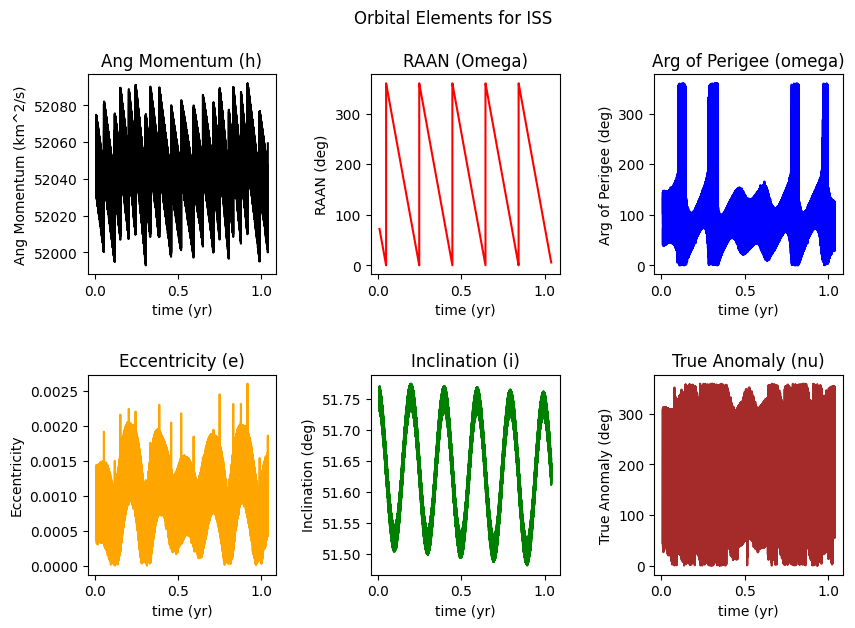

In [7]:
h_list, e_list, __, __, __, __, __ = return_coe(data)
threshold_h = 20000
threshold_e = 0.01
h_array = np.array(h_list)
e_array = np.array(e_list)
mask = (h_array > threshold_h) & (e_array < threshold_e)
mask_series = pd.Series(mask)
data_filtered = data[mask_series].reset_index(drop=True)

data_reduced = data_filtered[::10]
data_reduced = data_reduced.reset_index(drop=True)
plot_coe(data_reduced)

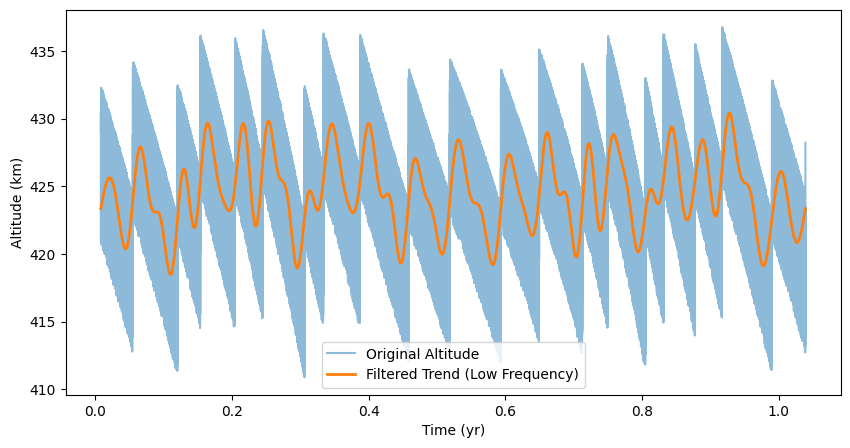

In [8]:
h_arr, e_arr, Omega_arr, i_arr, omega_arr, nu_arr, time_arr = return_coe(data_reduced)
h_arr = np.array(h_arr)
mu_Earth = 3.986004418e5
r_arr = h_arr ** 2 / mu_Earth
alt_arr = r_arr - 6371
fft_values = fft(alt_arr)
fft_freq = fftfreq(len(alt_arr), d=time_arr[1] - time_arr[0])
cutoff_frequency = 40  # Define a cutoff frequency for filtering
fft_values_filtered = np.where(np.abs(fft_freq) > cutoff_frequency, 0, fft_values)
altitude_trend = ifft(fft_values_filtered).real
plt.figure(figsize=(10, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)
plt.xlabel('Time (yr)')
plt.ylabel('Altitude (km)')
plt.legend()
plt.show()

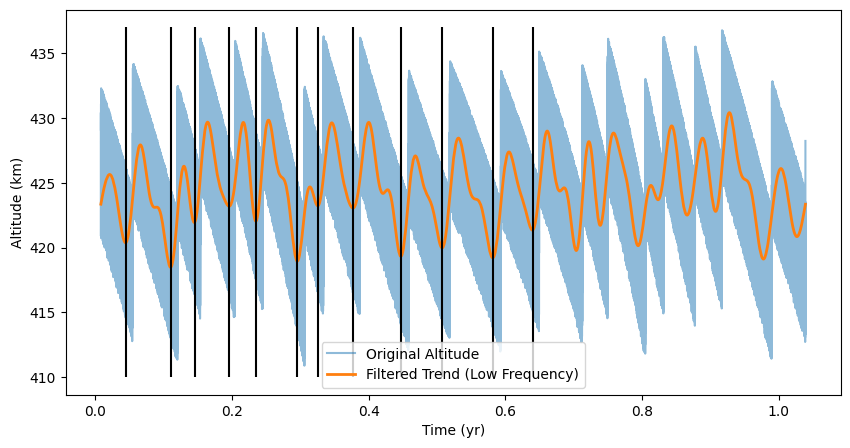

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)
plt.xlabel('Time (yr)')
plt.ylabel('Altitude (km)')
plt.vlines(.045, 410, 437, colors = 'black')
plt.vlines(.111, 410, 437, colors = 'black')
plt.vlines(.146, 410, 437, colors = 'black')
plt.vlines(.196, 410, 437, colors = 'black')
plt.vlines(.235, 410, 437, colors = 'black')
plt.vlines(.295, 410, 437, colors = 'black')
plt.vlines(.3255, 410, 437, colors = 'black')
plt.vlines(.377, 410, 437, colors = 'black')
plt.vlines(.447, 410, 437, colors = 'black')
plt.vlines(.508, 410, 437, colors = 'black')
plt.vlines(.582, 410, 437, colors = 'black')
plt.vlines(.640, 410, 437, colors = 'black')
plt.legend()
plt.show()

## Random Forest Classifier

In [10]:
# Step 1: Import synthetic data
time_series = altitude_trend
jumps_list = len(time_arr)/time_arr[-1] * np.array([.045, .111, .146, .196, .235, .295, .3255, .377, .447, .508, .582, .640])
jumps = [int(x) for x in jumps_list]

# Step 2: Feature extraction
diff_series = np.diff(time_series, prepend=time_series[0])

# Step 3: Label data
labels = np.zeros(len(diff_series))
labels[jumps] = 1

# Step 4: Prepare data for the model
X = diff_series.reshape(-1, 1)
y = labels

# Split data into training and testing sets
X_train = X[:22000]
y_train = y[:22000]
X_test = X[22000:]
y_test = y[22000:]

# Step 5: Train model
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Step 6: Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

new_diff = np.diff(altitude_trend, prepend=alt_arr[0])
new_predictions = model.predict(new_diff.reshape(-1, 1))

print('Predictions on new data:', new_predictions)

predicted_jumps = np.where(new_predictions == 1)[0]
print('Indices of predicted jumps:', predicted_jumps)

# Step 7: Make predictions on new data
new_data = np.cumsum(np.random.randn(30)) + 410
new_diff = np.diff(new_data, prepend=new_data[0])
new_predictions = model.predict(new_diff.reshape(-1, 1))

print('Predictions on new data:', new_predictions)

Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Predictions on new data: [0. 0. 0. ... 0. 0. 0.]
Indices of predicted jumps: [ 1447  3569  4695  6303  7557  9487 10468 12124 14375 16337 18717 20583
 22971 23804 25691 25877 26587 26640 28111 29519 29680 31952 32092 33355]
Predictions on new data: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'Random Forest Classifier: Synthetic ISS Orbit Raises')

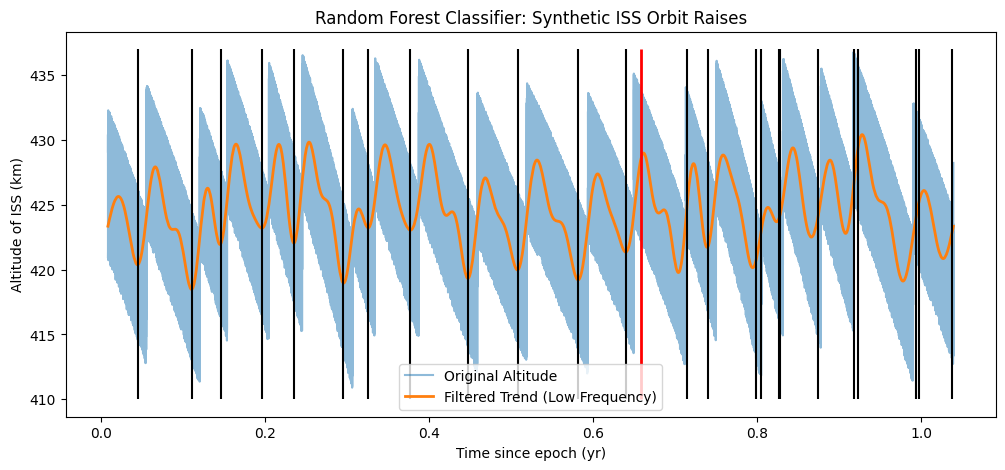

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)
for jump in predicted_jumps:
  plt.vlines(jump * time_arr[-1]/len(time_arr), 410, 437, colors = 'black')
plt.xlabel('Time since epoch (yr)')
plt.ylabel('Altitude of ISS (km)')
plt.legend()
plt.vlines(22000/len(altitude_trend), 410, 437, colors='r', lw = 2)
plt.title('Random Forest Classifier: Synthetic ISS Orbit Raises')

## Neural Network Classifier

In [12]:
# Step 1: Import synthetic data
time_series = altitude_trend
jumps_list = len(time_arr)/time_arr[-1] * np.array([.045, .111, .146, .196, .235, .295, .3255, .377, .447, .508, .582, .640])
jumps = [int(x) for x in jumps_list]

# Step 2: Feature extraction
diff_series = np.diff(time_series, prepend=time_series[0])

# Step 3: Label data
labels = np.zeros(len(diff_series))
labels[jumps] = 1  # Binary labels: 0 = no jump, 1 = jump

# Step 4: Prepare data for model
X = diff_series.reshape(-1, 1)
y = labels

X_train = X[:22000]
y_train = y[:22000]
X_test = X[22000:]
y_test = y[22000:]

# Step 5: Compute class weights
set_seed(1)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
print(f"Class weights: {class_weights}")

# Step 6: Build and train neural network (sigmoid binary output)
model = Sequential([
    Dense(16, input_dim=1, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # One output node for binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model with class weights
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, class_weight=class_weights)

# Step 7: Evaluate model
y_pred_probs = model.predict(X_test).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Step 8: Predict on entire trend
new_diff = np.diff(altitude_trend, prepend=alt_arr[0])
new_probs = model.predict(new_diff.reshape(-1, 1)).flatten()
new_pred_classes = (new_probs > 0.5).astype(int)
predicted_jumps = np.where(new_pred_classes == 1)[0]

print('Predictions on full data:', new_pred_classes)
print('Indices of predicted jumps:', predicted_jumps)

Class weights: {0: np.float64(0.5002728761142441), 1: np.float64(916.6666666666666)}
Epoch 1/20


C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.9893 - loss: 0.6036
Epoch 2/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.9996 - loss: 0.5983
Epoch 3/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9996 - loss: 0.5995
Epoch 4/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9996 - loss: 0.6004
Epoch 5/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.9996 - loss: 0.6009
Epoch 6/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - accuracy: 0.9996 - loss: 0.6012
Epoch 7/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.9987 - loss: 0.6014
Epoch 8/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.9975 - loss: 0.6015
Epoch 9/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.9772 - loss: 0.6015
Epoch 10/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.9307 - loss: 0.6012
Epoch 11/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.8799 - loss: 0.6010
Epoch 12/20
688/688 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\billy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Predictions on full data: [0 1 1 ... 1 1 1]
Indices of predicted jumps: [    1     2     3 ... 33418 33419 33420]


Text(0.5, 1.0, 'Neural Network Classifier: Synthetic ISS Orbit Raises')

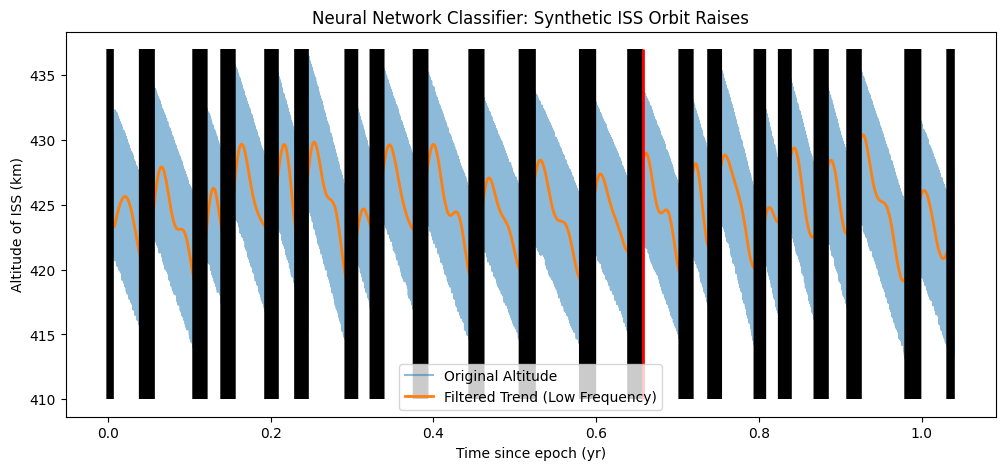

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)
for jump in predicted_jumps:
  plt.vlines(jump * time_arr[-1]/len(time_arr), 410, 437, colors = 'black')
plt.xlabel('Time since epoch (yr)')
plt.ylabel('Altitude of ISS (km)')
plt.legend()
plt.vlines(22000/len(altitude_trend), 410, 437, colors='r', lw = 2)
plt.title('Neural Network Classifier: Synthetic ISS Orbit Raises')

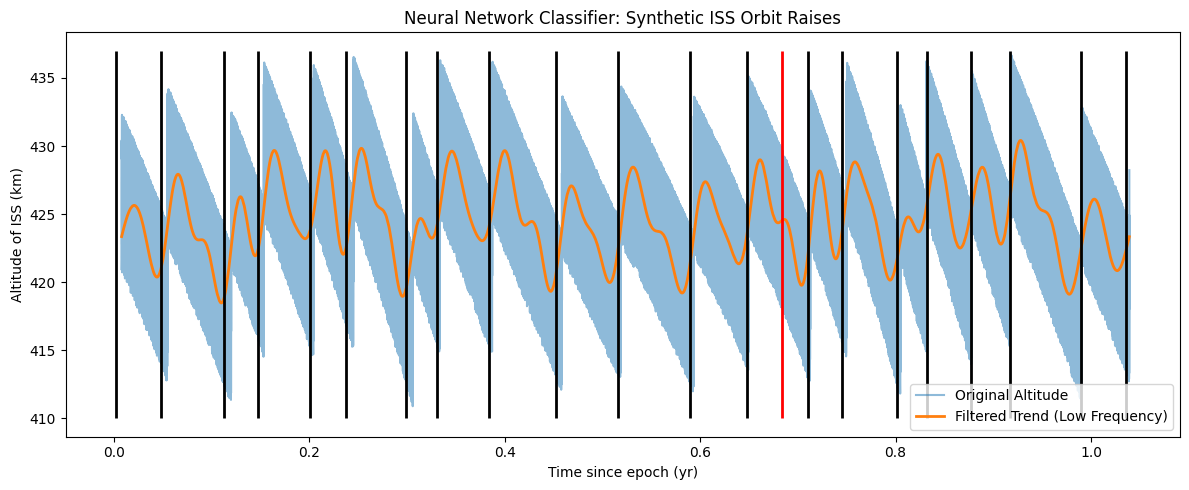

In [14]:
jump_medians, _ = group_predicted_jumps(predicted_jumps)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)

# Plot only median jump per band
for jump in jump_medians:
    t_jump = jump * time_arr[-1] / len(time_arr)
    plt.vlines(t_jump, 410, 437, colors='black', linewidth=2)

# Mark training/test boundary
plt.vlines(22000 / len(altitude_trend) * time_arr[-1], 410, 437, colors='r', lw=2)

plt.xlabel('Time since epoch (yr)')
plt.ylabel('Altitude of ISS (km)')
plt.legend()
plt.title('Neural Network Classifier: Synthetic ISS Orbit Raises')
plt.tight_layout()
plt.show()

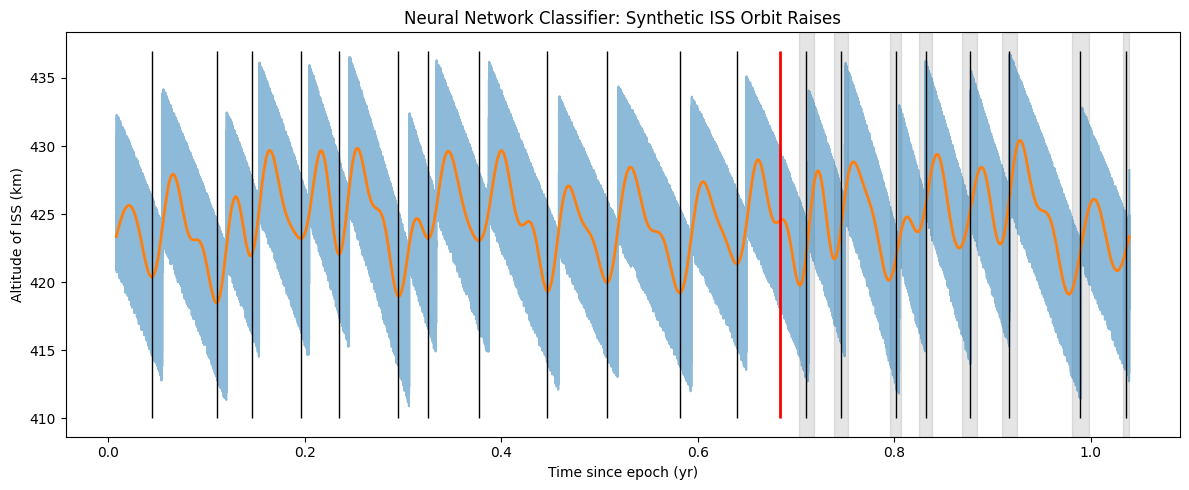

In [15]:
# Define the red line index threshold
split_index = 22000
split_time = split_index / len(time_arr) * time_arr[-1]

# Split the predicted jumps
predicted_right = [idx for idx in predicted_jumps if idx >= split_index]
predicted_medians, predicted_bands = group_predicted_jumps(predicted_right)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(time_arr, alt_arr, label='Original Altitude', alpha=0.5)
plt.plot(time_arr, altitude_trend, label='Filtered Trend (Low Frequency)', linewidth=2)

# --- Plot actual jumps (left of red line)
for jump in jumps:
    t_jump = jump * time_arr[-1] / len(time_arr)
    if jump < split_index:
        plt.vlines(t_jump, 410, 437, colors='black', linewidth=1)

# --- Plot predicted bands (right of red line)
for band_start, band_end in predicted_bands:
    t_start = band_start * time_arr[-1] / len(time_arr)
    t_end = band_end * time_arr[-1] / len(time_arr)
    plt.axvspan(t_start, t_end, color='black', alpha=0.1)  # translucent band

# --- Plot predicted medians (right of red line)
for median in predicted_medians:
    t_median = median * time_arr[-1] / len(time_arr)
    plt.vlines(t_median, 410, 437, colors='black', linewidth=1)

# Red line for train/test split
plt.vlines(split_time, 410, 437, colors='red', lw=2)

plt.xlabel('Time since epoch (yr)')
plt.ylabel('Altitude of ISS (km)')
plt.title('Neural Network Classifier: Synthetic ISS Orbit Raises')
plt.tight_layout()
plt.show()